## Is there a connection between stock prices and tweets? 
<div>
    <font size="4">Remember this headline from the last month?</font> <br><br>
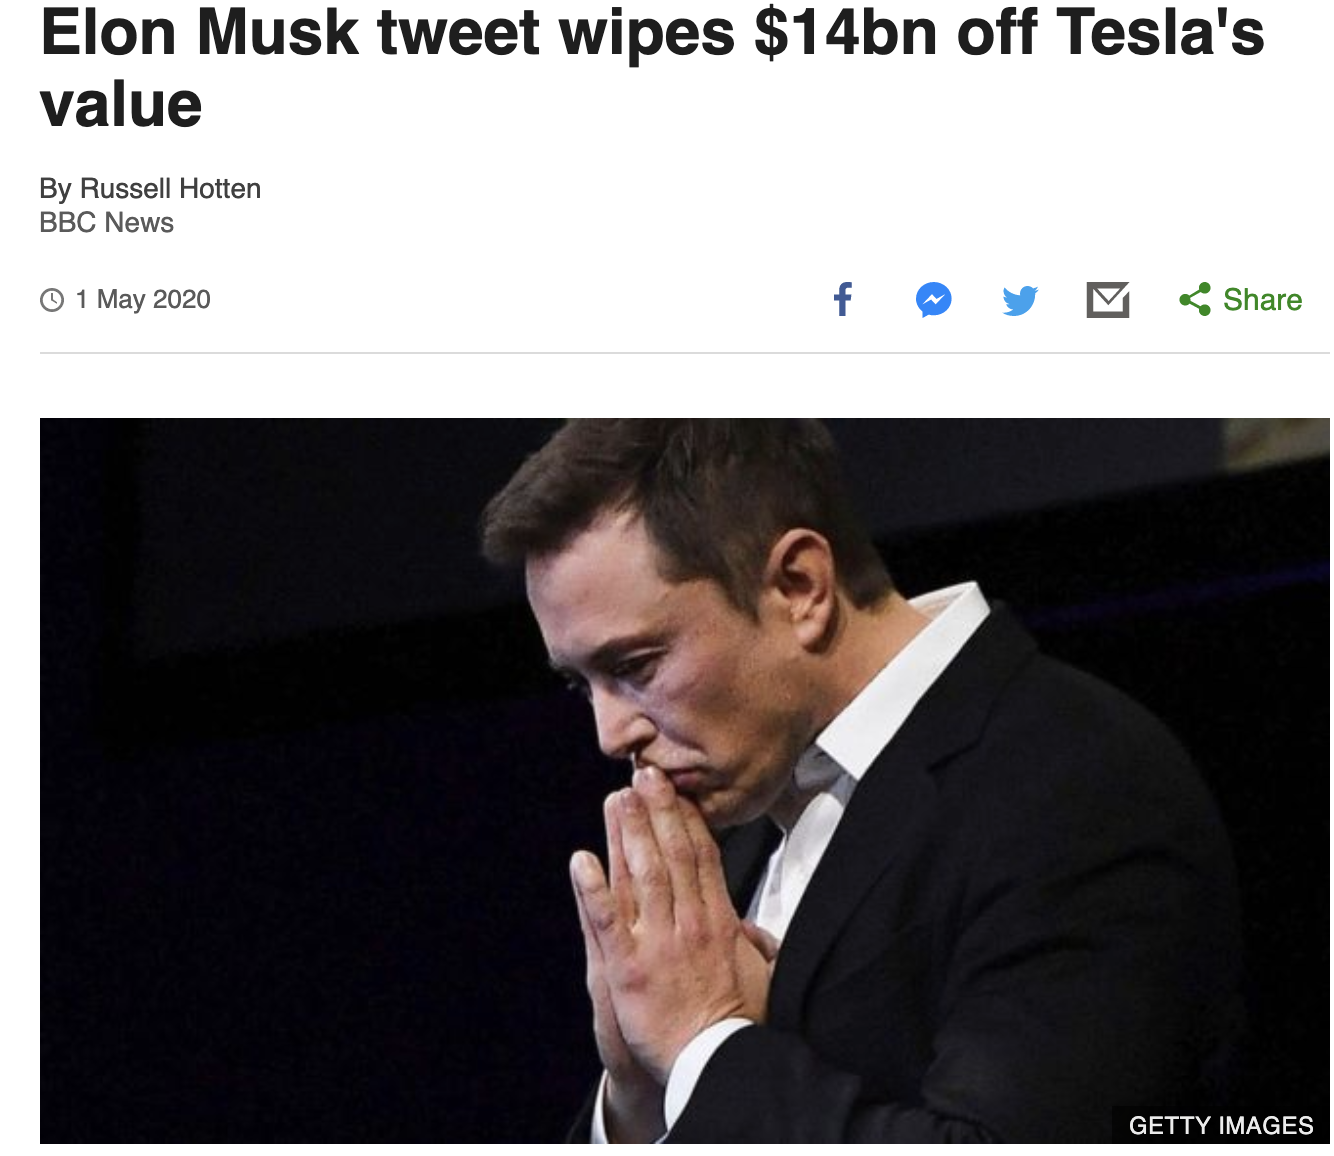
</div>
<br>
<font size="4">While intuitively wit does make sense that there should be a connection between the tweets of famous industrialists and the stock prices of their brands, it is still interestig to confirm this 
with real numbers.<br><br>In this blog I try to investigate this using Elon Musk's tweets and the stock prices of Tesla inc. for the last one year.</font>

<font size="4">First let's import some necessary modules.</font>

In [421]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import tweepy as tw
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
import re
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

<font size="4">Let's define a class for grabbing the tweets from a user's timeline (we will also remove the non-ASCII characters from the tweet).</font>

In [461]:
'''
Tweet Grabber class for grabbing tweets
'''

class TweetGrabber():
    
    def __init__(self,myApi,sApi,at,sAt):
        import tweepy
        self.tweepy = tweepy
        
        # create the OAuthHandler instance
        auth = tweepy.OAuthHandler(myApi, sApi)
        # provide the access token
        auth.set_access_token(at, sAt)
        # create the API wrapper
        self.api = tweepy.API(auth)
        
        
    def strip_non_ascii(self,string):
        ''' Returns the string without non ASCII characters'''
        stripped = (c for c in string if 0 < ord(c) < 127)
        return ''.join(stripped)
        
        
    def user_search(self,user,csv_prefix):
        '''returns tweets from the twitter timeline of a user'''
        import csv
        results = self.tweepy.Cursor(self.api.user_timeline,id=user,tweet_mode='extended').items()

        # write the results in a csv file
        with open(f'{csv_prefix}.csv', 'w', newline='') as csvfile:
            fieldnames = ['tweet_id', 'tweet_text', 'date','retweet_count']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()

            for tweet in results:
                text = self.strip_non_ascii(tweet.full_text)
                date = tweet.created_at.strftime('%m/%d/%Y')        
                writer.writerow({
                                'tweet_id': tweet.id_str,
                                'tweet_text': text,
                                'date': date,
                                'retweet_count': tweet.retweet_count
                                })        

<font size="4">Now we will grab tweets from Elon Musk's twitter timeline</font>

In [217]:
t = TweetGrabber(
    myApi = '############',
    sApi = '############',
    at = '############',
    sAt = '############')

t.user_search(user='elonmusk',csv_prefix='elon_musk_tweets')

<font size="4">In the file `elon_musk_tweets.csv` we found around 3200 tweets which is about the maximum number of tweets twitter allows to be accessed in one API call. The oldest tweet was from 22<sup>nd</sup> July 2019 and the latest was from 2<sup>nd</sup> July 2020.</font>

<font size="4">Next we will read the csv file and will remove all urls from the tweet texts.</font>

In [218]:
def remove_url(txt):
    """Remove the URLs from the string. """
    
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url = url_pattern.sub(r'', txt)

    return no_url


In [220]:
import pandas as pd
# define a date parser based on the date format in the csv file
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')

# read the csv file; read the dates based on the date parser
tweets = pd.read_csv('elon_musk_tweets.csv', parse_dates=['date'], date_parser=dateparse)

# remove urls from the 'tweet_text' column
tweets['tweet_text'] = [remove_url(text) for text in tweets['tweet_text']]

<font size="4">We arrange the tweets in increasing order of dates.</font>

In [422]:
# sort the tweets dataframe based on increasing dates
tweets_sort = tweets.sort_values(by='date')
#tweets_sort.columns

<font size="4">We create per day date intervals between 22nd July 2019 and 2nd July 2020</font>

In [276]:
from datetime import datetime, timedelta

date_intervals = pd.interval_range(start=pd.Timestamp('2019-07-22'), freq='1D', end=pd.Timestamp('2020-07-02'), closed='left')

# arange all the dates between 22nd July 2019 and 2nd July 2020
dates = np.arange(datetime(2019,7,22), datetime(2020,7,2), timedelta(days=1)).astype(datetime)

## Retweet Count analysis

<font size="4">Retweets are an interesting metric for assessing the mood of the public that may affect the stock prices.</font>

<font size="4">We first group the tweet texts and retweet counts in the dataframe for each day based on the date_intervals.</font>

In [250]:
tweet_text_grp = []; retweet_count_grp=[]
for interval in date_intervals:
    tweet_text_grp.append([tweets_sort['tweet_text'][index] for index in tweets_sort.index if tweets_sort['date'][index] in interval])
    retweet_count_grp.append([tweets_sort['retweet_count'][index] for index in tweets_sort.index if tweets_sort['date'][index] in interval])

<font size="4">Next we create a list of average retweet counts per day</font>

In [252]:
retweet_cl = [np.sum([retweetc for retweetc in retweetcg]) for retweetcg in retweet_count_grp]

## Total retweet counts per day

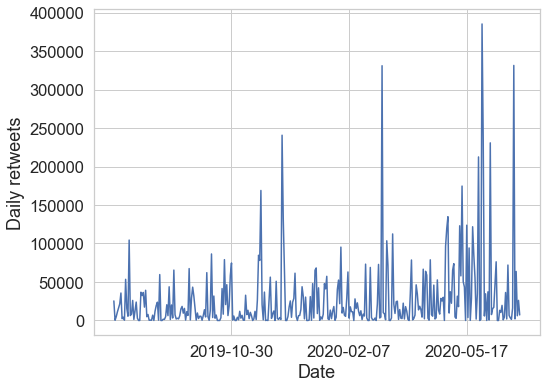

In [445]:
fig, ax = plt.subplots(figsize=(8,6))
x_values = [100,200,300]

# convert to corresponding date labels
dates_labels = [dates[x].strftime("%Y-%m-%d") for x in x_values]

ax = plt.gca()
# get axes


ax.set_xticklabels(dates_labels)
ax.set_xticks(x_values)

ax.set_xlabel('Date')
ax.set_ylabel('Daily retweets')
plt.plot(retweet_cl)

<font size="4">Since sentiments about tweets may spread over several days, it makes sense to smooth the daily retweet counts.</font>

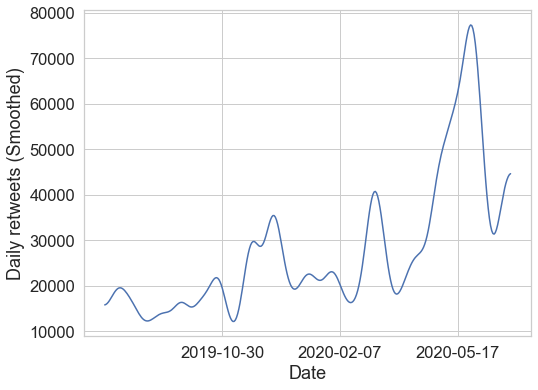

In [446]:
# smoothing the daily retweet counts

from scipy.ndimage import gaussian_filter1d


fig, ax = plt.subplots(figsize=(8,6))
x_values = [100,200,300]

# convert to corresponding date labels
dates_labels = [dates[x].strftime("%Y-%m-%d") for x in x_values]

ax = plt.gca()

ax.set_xticklabels(dates_labels)
ax.set_xticks(x_values)
ax.set_xlabel('Date')
ax.set_ylabel('Daily retweets (Smoothed)')
retweet_scl = gaussian_filter1d(retweet_cl, 7)
plt.plot(retweet_scl)

## Tesla Stock Prices

<font size="4">We obtain the Tesla closing stock prices for each day for the last one year from https://finance.yahoo.com/</font>

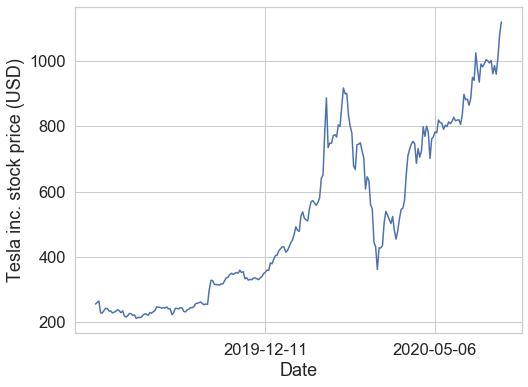

In [457]:
# define a date parser based on the date format in the csv file for the TESLA  stock prices
# for the last one year

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

# read the csv file for the TESLA  closing stock prices for each day for the last one year
# (reading the dates based on the date parser)

TSLA_stk_price_df = pd.read_csv('TSLA.csv', parse_dates=['Date'], date_parser=dateparse)
TSLA_stk_price = TSLA_stk_price_df['Close']

fig, ax = plt.subplots(figsize=(8,6))
x_values = [100,200]
# convert to corresponding date labels
dates_labels = [TSLA_stk_price_df['Date'][x].strftime("%Y-%m-%d") for x in x_values]
ax = plt.gca()
ax.set_xticklabels(dates_labels)
ax.set_xticks(x_values)
ax.set_xlabel('Date')
ax.set_ylabel('Tesla inc. stock price (USD)')

# plot the stock prices
plt.plot(TSLA_stk_price)

## Comparing the stock prices with retweet counts

<font size="4">Since the stock prices dataframe is missing some dates we select only those values from the daily total retweet count list, for which the dates are present in the stock prices dataframe.</font>

In [443]:
retweet_cl_new = []; dates_new=[]
ind2=0
for ind1 in range(len(dates)):
    if dates[ind1] == TSLA_stk_price_df['Date'][ind2]:
        retweet_cl_new.append(retweet_cl[ind1])
        dates_new.append(dates[ind1])
        ind2+=1
    

## Tesla Stock prices vs. Elon Musk's daily retweet counts

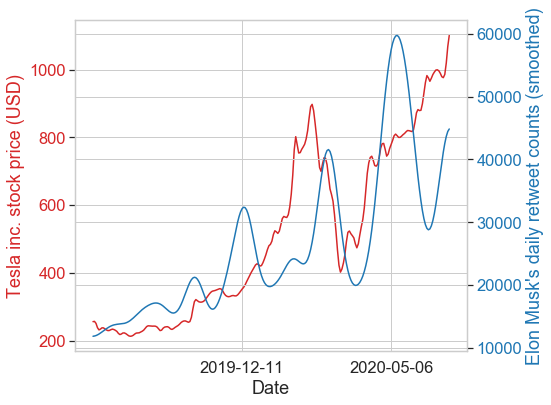

In [459]:
# plotting the Tesla stock prices and Elon Musk's retweet counts 

fig, ax1 = plt.subplots(figsize=(8,6))

# smoothing periods for Tesla stock prices and retweet counts
p1=1; p2=7

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Tesla inc. stock price (USD)', color=color)
ax1.plot(gaussian_filter1d(TSLA_stk_price_df['Close'], p1) , color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("Elon Musk's daily retweet counts (smoothed)", color=color)  # we already handled the x-label with ax1
ax2.plot(gaussian_filter1d(retweet_cl_new, p2), color=color)
ax2.tick_params(axis='y', labelcolor=color)

x_values = [100,200]
# convert to corresponding date labels
dates_labels = [TSLA_stk_price_df['Date'][x].strftime("%Y-%m-%d") for x in x_values]
ax = plt.gca()
ax.set_xticklabels(dates_labels)
ax.set_xticks(x_values)


fig.tight_layout()  # otherwise the right y-label is slightly clipped

<br><br>
<font size="4">As you can see there is clearly a correlation between the two values.<br>
Let's calculate the correlation coefficient.</font>
<br>

In [424]:
from scipy.stats import pearsonr

# calculate Pearson's correlation
corr, _ = pearsonr(gaussian_filter1d(TSLA_stk_price_df['Close'], p1), gaussian_filter1d(retweet_cl_new, p2))
print(corr)

0.7359935314855618


<br>
<font size="4">We find that the pearson's correlation coefficient between the Tesla stock prices and Elon Musk's retweet counts is ~0.74, which is a pretty strong correlation.</font>
<br><br>

## Sentiment analysis

<font size="4">We also thought that the sentiment values of the tweets should also be an important parameter that should also be connected with the stock prices.<br><br>
For this, we use the Python package textblob that calculates the polarity values of individual tweets.</font>

In [348]:
from textblob import TextBlob

# Create textblob objects of the tweets
sentiment_objects = [[TextBlob(tweet) for tweet in grp] for grp in tweet_text_grp]

<br>
<font size="4">We create a list of the sentiment/polarity values.</font>
<br>

In [349]:
sentiment_values = [np.mean([tweet.sentiment.polarity for tweet in tweetg]) for tweetg in sentiment_objects]

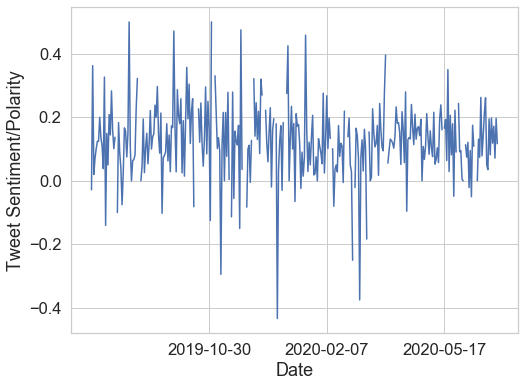

In [460]:
# plotting the sentiment values
fig, ax = plt.subplots(figsize=(8,6))
x_values = [100,200,300]

# convert to corresponding date labels
dates_labels = [dates[x].strftime("%Y-%m-%d") for x in x_values]

ax = plt.gca()
# get axes


ax.set_xticklabels(dates_labels)
ax.set_xticks(x_values)
ax.set_xlabel('Date')
ax.set_ylabel('Tweet Sentiment/Polarity')
plt.plot(sentiment_values)

<font size="4">Contary to our intuition, the sensitivity values do not show any clear trend. We note that it will probably make more sense to calculate the sentiment values of the replies to Elon Musk's tweets. But given the twitter constraints on accessing tweets, we realise that that will be a very time consuming analysis, so we will stop our analysis here.</font>